## Overview
The purpose of this project is to implement the following CNN model for musical genre classification: https://publik.tuwien.ac.at/files/publik_256008.pdf

This project was done as part of the CMPE452 - Neural Networks course.

The paper trains the model on several datasets. The GTZAN dataset was selected for this implementation due to its coverage of a variety of genres (10 genres) and appropriate size for this task. The ISMIR dataset only contains samples across 6 genres, the Latin music database contains songs specific to latin genres so would not generalize well to Western music (which is the focus of this project for the sake of applicability in the West), and the Million song dataset was deemed too large for this project. The paper results with this dataset were also rather poor with this dataset.

The GTZAN dataset stores all audio at a frequency of 22.1KHz, in mono 16-bit format. 

In [22]:
import os
from pathlib import Path
import librosa
import librosa.display
import numpy as np
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
from keras.regularizers import l1
from keras.models import Model
import keras
from tensorflow.keras.optimizers import Adam
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
#specify paths to GTZAN dataset and path to save preprocessed data
GTZAN_dir = ".\genres"

## Data exploration
The GTZAN dataset consists of 1000 songs split evenly between 10 classes. Each `genre` directory has a
single .wav file per audio track, each being a 30s clip of the song. A single audio sample is plotted below.

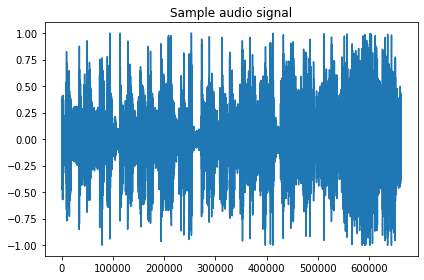

In [3]:
signal, sr = librosa.load(GTZAN_dir + '/pop/pop.00000.wav')
plt.plot(signal)
plt.title('Sample audio signal')
plt.tight_layout()
plt.show()

## Data augmentation
To increase the amount of usable training data, two methods were used. The first was time stretching, where the audio signal is slowed down, but the notes keep the same frequency (pitch). An example halving the song tempo is shown below:

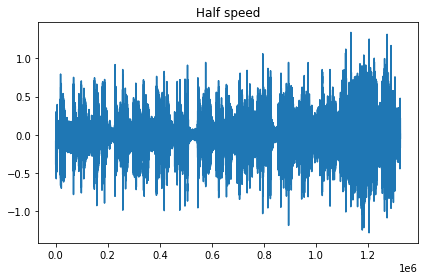

In [4]:
stretched = librosa.effects.time_stretch(signal, rate=0.5)
plt.plot(stretched)
plt.title('Half speed')
plt.tight_layout()
plt.show()

The second method is pitch shifting, where the pitch of the audio signal is raised or lowered by some number of semitones. An example increasing the signal by 1 semitone.

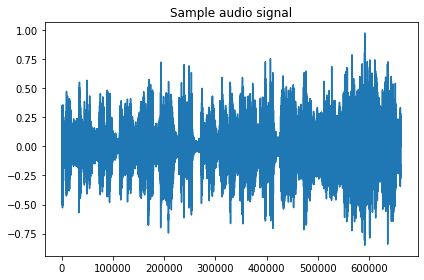

In [5]:
pitched_up = librosa.effects.pitch_shift(signal, sr=sr, n_steps=1)
plt.plot(pitched_up)
plt.title('Sample audio signal')
plt.tight_layout()
plt.show()

## 

## Preprocessing
The audio signals needed to be preprocessed in a way that can be understood by the CNN model, **this takes place after augmenting a song's audio**. In this case, the audio signals were converted to Mel-spectrogram coefficients. This involves producing spectrograms of each signal, the converting to the Mel scale. 

Spectrograms come from doing a short-time Fourier transform on the audio. A fast fourier transform is done on windowed segments of the signal. The "hop_length" parameter specifies the number of data points that are skipped before the start of the next segment, while "win_length" is the number of data points in each segment. 

The y-axis amplitudes are also converted to a log scale (decibels). 

<img src="images/stft-diagram.PNG" width=600 height=600 />
Credit: https://www.mathworks.com/help/dsp/ref/dsp.stft.html

The decibel values are converted to the Mel scale, which was created to reflect the idea that humans can more easily detect the difference in lower frequencies than higher ones. The Mel scale uses a unit of pitch where equal distances sound equally distant to a listener. 

<img src="images/mel-scale.png" width=400 height=400 />
Credit: https://www.sfu.ca/sonic-studio-webdav/handbook/Mel.html

A win_length of 1024 was used. Given a 44.1KHz sampling rate, this constant window size results in ~50ms of audio per window. A 0.93s sample of audio is randomly selected for preprocessing, based on the time it takes a human to recognize the genre of a piece of music. A hop_length of 256 was selected, mainly to produce a (80, 80) Mel-spectrogam coefficient matrix which balances the contribution of time and frequency components. 

This idea is reflected in the model design, which is described later on. 

For each song, 3 0.93s sample are randomly selected to be used for training. Each sample is augmented using 16 time and pitch shifting combinations, coming from 4 time shifting factors (0.2, 0.5, 1.2, 1.5) and 4 pitch shifting factors (±2, ±5). This results in a total of 51 samples per song. 

The full preprocessing code is shown below. The preprocessed samples are saved to `save_dir`, which is set to generate `.\GTZAN_preprocessed` by default.

In [6]:
save_dir = ".\GTZAN_preprocessed"

In [7]:
#class to handle preprocessing
class Preprocessor():
    def __init__(self, GTZAN_dir, save_dir):
        """constructor"""
        #load dataset, segment into classes
        self.GTZAN_dir = GTZAN_dir
        self.save_dir = save_dir
        self.sr = 22050
        
        self.timeFactorOpts = [0.5, 0.2, 1.2, 1.5]
        self.pitchShiftOpts = [2, -2, 5, -5]
        #generate tuple of (timeOpt, pitchOpt) for augmenting
        timeOptsGrid, pitchOptsGrid = np.meshgrid(self.timeFactorOpts, self.pitchShiftOpts)
        self.allAugmentOptions = np.array([timeOptsGrid,pitchOptsGrid]).transpose(1,2,0).reshape(1, 16, 2)[0]
        
        #make directories to save preprocessed sample files
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        for genreName in next(os.walk(self.GTZAN_dir))[1]:
            if not os.path.exists(Path(self.save_dir, genreName)):
                os.mkdir(Path(self.save_dir, genreName))

    def _augment_sample(self, sound, time_factor=1, semitone_shift=0):
        """apply time shifting and / or pitch shifting to augment"""
        if time_factor != 1:
            sound = librosa.effects.time_stretch(sound, rate=time_factor)
        if semitone_shift != 0:
            sound = librosa.effects.pitch_shift(sound, sr=self.sr, n_steps=semitone_shift)
        return sound
        
    def _get_mel_spectrogram(self, sound):
        """get mel spectrogram then convert to dB scale"""
        mel_freq = librosa.feature.melspectrogram(y = sound, sr=self.sr, win_length=1024, hop_length=256, n_mels=80)
        ps_db = librosa.power_to_db(mel_freq, ref=np.max)
        return ps_db
    
    def _get_preprocessed_sample(self, sound, time_factor=1, semitone_shift=0):
        """preprocess a song sample"""
        sound = self._augment_sample(sound, time_factor, semitone_shift)
        
        #cut to first 0.93s
        frac = int(0.93 * self.sr)
        sound_snip = sound[:frac]

        #get mel spectrogram then convert to dB scale
        ps_db = self._get_mel_spectrogram(sound_snip)

        #pop last column to get correct output shape
        ps_db = np.delete(ps_db, -1, axis=1)

        return ps_db
        
    def _get_random_samples(self, sound, N = 3, sampleLength = 1.4):
        """Get random samples from a song, ensuring no overlap"""
        samples = np.zeros((N, int(sampleLength * self.sr)))
        #define possible song segments
        songLength = librosa.get_duration(y=sound)
        segs = [i for i in range(int(songLength // sampleLength))]

        #get N random unique segments
        seg_inds = random.sample(segs, N)
        sample_inds = np.array(seg_inds) * int(sampleLength * self.sr)

        #combine
        for i in range(N):
          samples[i] = sound[sample_inds[i] : sample_inds[i] + int(sampleLength * self.sr)]
        return samples
    
    def _preprocess_song(self, genre, filepath):
        """generate augmented samples from 3 random samples of the song audio, save to file"""
        sound, _ = librosa.load(str(filepath))
        allSongSamples = np.zeros((51, 80, 80))

        #get 3 random song samples (without overlap)
        samples = self._get_random_samples(sound)

        #preprocess the samples
        for i in range(3):
            allSongSamples[17 * i, :, :] = self._get_preprocessed_sample(samples[i])
            #generate all 4 x 4 = 16 augmented samples
            for j, (t, p) in enumerate(self.allAugmentOptions):
                allSongSamples[17 * i + j + 1, :, :] = self._get_preprocessed_sample(samples[i],t, p)
            
        np.save(Path(self.save_dir, genre, os.path.basename(filepath)), allSongSamples)
        
    def preprocess_songs(self, sample=False):
        """Do preprocessing for all GTZAN songs"""
        if sample:
            [self._preprocess_song("rock", Path(self.GTZAN_dir, f"rock/rock.0000{i}.wav")) for i in range(5)]                             
        else:
            #iter genres
            for gname in next(os.walk(self.GTZAN_dir))[1]:
                genredir = Path(self.GTZAN_dir, gname)
                #iter songs
                for songname in next(os.walk(genredir))[2]:
                    songpath = Path(genredir, songname)
                    self._preprocess_song(gname, songpath)

## Model architecture
A customized CNN was used as the model, based on the idea that both time and frequency components of the audio signal are relevant to genre classification. 

The (80, 80) Mel-spectrogram coefficient matrix is fed into 2 separate convolution and max pooling pipelines. The frequency pipeline consists of convolution kernels which mainly extract feature maps from frequency components of the data, while the time pipeline mainly extracts time components. 

The final output from each pipeline is flattened and concatenated, then fed into a dense layer with dropout. Finally, a classification layer with Softmax activation returns the class probability distribution for the sample. 

## Training
Stratified K-fold cross validation was used. K-fold was used to gain an understanding of how much the model performance changes with different data splits. Stratification was necessary to ensure the genre distribution in each train and validation dataset remained even. I made sure that no samples derived from the same song were split between the train and val sets, since this would mean the model isn't validating on novel data.

In [41]:
#model class
class CNN_2PIPELINE:
    def __init__(self, save_dir):
        """Constructor"""
        #define array of numerical categories for songs, to split up when separating the songs into folds for K-fold
        self.y = np.repeat(np.arange(10), 100) #[0, 0, ..., 0, 1, 1, ...]
        self.save_dir = save_dir
        self.labelmap = {0: "blues", 1: "classical", 2: "country", 3: "disco", 4: "hiphop", 
                5: "jazz", 6: "metal", 7: "pop", 8: "reggae", 9: "rock"}
        
    def load_from_weights(self, weightspath):
        self.model = self._build_model()
        self.model.load_weights(weightspath).expect_partial()
        
    def load_data(self, dataDir):
        """Load all training samples from filesystem"""
        allData = np.zeros((51000, 80, 80))

        #iter genres
        genreInd = 0
        for gname in next(os.walk(dataDir))[1]:
            print(f"Loading genre {gname}")
            genredir = Path(dataDir, gname)
            songInd = 0

            #iter songs
            for songname in next(os.walk(genredir))[2]:
                #load song coeffs
                trainDataPath = Path(dataDir, gname, songname)
                sind = genreInd * 5000 + songInd * 50
                eind = sind + 50
                data = np.load(trainDataPath)
                if data.shape == (51, 80, 80):
                  allData[sind : eind, :, :] = data[1:, :, :]
                else:
                  allData[sind : eind, :, :] = np.load(trainDataPath)

                songInd += 1
            genreInd += 1

        self.allData = allData
        
        
    def _build_model(self):
        #Mel-spectrogram input
        model_input = Input((80, 80, 1), name='input')
        
        #apply regularization to ALL trainable params
        reg = l1(0.0001)
        kwargs = {"kernel_regularizer": reg, 
                 "bias_regularizer": reg}
        
        #frequency pipeline
        #layer 1
        freq_layer = keras.layers.Conv2D(filters=16, kernel_size=(10, 23), **kwargs)(model_input)
        freq_layer = keras.layers.LeakyReLU(alpha=0.3)(freq_layer)
        freq_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(freq_layer)
        #layer 2
        freq_layer = keras.layers.Conv2D(filters=32, kernel_size=(5, 11), **kwargs)(freq_layer)
        freq_layer = keras.layers.LeakyReLU(alpha=0.3)(freq_layer)
        freq_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(freq_layer)
        #layer 3
        freq_layer = keras.layers.Conv2D(filters=64, kernel_size=(3, 5), **kwargs)(freq_layer)
        freq_layer = keras.layers.LeakyReLU(alpha=0.3)(freq_layer)
        freq_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(freq_layer)
        #layer 4
        freq_layer = keras.layers.Conv2D(filters=128, kernel_size=(2, 2), **kwargs)(freq_layer)
        freq_layer = keras.layers.LeakyReLU(alpha=0.3)(freq_layer)
        freq_layer = keras.layers.MaxPooling2D(pool_size=(5, 1))(freq_layer)

        #time pipeline
        #layer 1
        time_layer = keras.layers.Conv2D(filters=16, kernel_size=(23, 10), **kwargs)(model_input)
        time_layer = keras.layers.LeakyReLU(alpha=0.3)(time_layer)
        time_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(time_layer)
        #layer 2
        time_layer = keras.layers.Conv2D(filters=32, kernel_size=(11, 5), strides=(1, 1), **kwargs)(time_layer)
        time_layer = keras.layers.LeakyReLU(alpha=0.3)(time_layer)
        time_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(time_layer)
        #layer 3
        time_layer = keras.layers.Conv2D(filters=64, kernel_size=(5, 3), **kwargs)(time_layer)
        time_layer = keras.layers.LeakyReLU(alpha=0.3)(time_layer)
        time_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(time_layer)
        #layer 4
        time_layer = keras.layers.Conv2D(filters=128, kernel_size=(2, 2), **kwargs)(time_layer)
        time_layer = keras.layers.LeakyReLU(alpha=0.3)(time_layer)
        time_layer = keras.layers.MaxPooling2D(pool_size=(1, 5))(time_layer)


        #flatten both 
        time_layer = keras.layers.Flatten()(time_layer)
        freq_layer = keras.layers.Flatten()(freq_layer)

        #merge (1, N) output
        layer = keras.layers.Concatenate()([time_layer, freq_layer])

        #dropout
        layer = Dropout(rate=0.25)(layer)

        #dense layer
        layer = keras.layers.Dense(200, **kwargs)(layer)
        layer = keras.layers.LeakyReLU(alpha=0.3)(layer)

        #softmax
        layer = keras.layers.Dense(10, **kwargs)(layer)
        model_output = keras.layers.Softmax()(layer)

        model = Model(model_input, model_output)
        
        #optimizer
        opt = Adam(learning_rate=0.0005, 
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-8)

        # compile model
        model.compile(
            loss='categorical_crossentropy',
            metrics=['accuracy'],
            optimizer=opt)
        
        return model
    
    def get_summary(self):
        model = self._build_model()
        model.summary()
        
    def _split_data_info_folds(self, y_folds, trainInds, testInds):
        """Split up all data into train and test datasets based on indices from folds"""
        #[a, b, c] -> [50*a : 50*(a+1), ...]
        x_train = np.zeros((37500, 80, 80))
        x_test = np.zeros((12500, 80, 80))
        y_train = np.zeros((37500, 10))
        y_test = np.zeros((12500, 10))

        for i, ind in enumerate(trainInds):
            x_train[50*i:50 * (i + 1), :, :] = self.allData[50 * ind : 50 * (ind + 1), :, :]
            #set labels based on index
            y_train[50*i:50 * (i + 1), :] = y_folds[ind]

        for i, ind in enumerate(testInds):
            x_test[50*i:50 * (i + 1), :, :] = self.allData[50 * ind : 50 * (ind + 1), :, :]
            #set labels based on index
            y_test[50*i:50 * (i + 1), :] = y_folds[ind]

        return x_train, x_test, y_train, y_test
        
    def train(self):
        """Train with 4-fold cross validation"""
        songs = np.arange(1000)
        
        #define onehot encoded label array to use for training
        onehotEnc = OneHotEncoder(sparse=False)
        onehotLabels = onehotEnc.fit_transform(np.arange(10).reshape(10, 1))
        y_folds_encoded = np.repeat([onehotLabels], 100, axis=1)[0] #gives (1000, 10)

        #use 4-fold validation (split up songs between folds)
        kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
        for i, (train_index, test_index) in enumerate(kf.split(np.zeros(len(self.y)), self.y)): #for each fold, get indices of songs to include in train / test set
            
            #save indices of validation data
            np.save(f'val_inds_{i}.npy', test_index)
            
            #get all songs in the train, test folds
            x_train, x_test, y_train, y_test = self._split_data_info_folds(y_folds_encoded, train_index, test_index)
            
            #callback to save weights
            cp_callback = keras.callbacks.ModelCheckpoint(filepath=f"{self.save_dir}/cp_{i}.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)
            #early stopping callback
            early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            
            #run training
            model = self._build_model()
            model.fit(x_train, y_train, batch_size=64, epochs=20, 
                  verbose=1, validation_data=(x_test, y_test), 
                  callbacks=[cp_callback, early_stop])

            model.save(f'model_{i}')
        
    def _decode_labels(self, ys):
        """Decode list of numerical class labels to genre strings"""
        return [self.labelmap[y] for y in ys]

    def predict(self, samples):
      """Get predicted label for a song
          samples: All samples belonging to a song
      """
      preds = np.zeros((51))
      for i, s in enumerate(samples):
        preds[i] = np.argmax(self.model.predict(s.reshape((1, 80, 80, 1))))

      #apply majority vote
      c = Counter(preds)
      return c.most_common(1)[0][0]

    def pred_songs(self, N=1000, val=False, val_inds=None):
      """Get predictions for N songs"""
      if not val:
          y_pred = np.empty((N))
          y_true = np.empty((N))

          for i in range(N):
            ind_ = np.random.randint(0, 1000)
            samples = self.allData[51 * ind_ : 51 * (ind_ + 1), :, :]
            y_pred[i] = int(self.predict(samples))
            y_true[i] = ind_  // 100
    
      else:
        assert val_inds is not None, "invalid argument for indices of validation data"
        y_pred = np.empty((len(val_inds)))
        y_true = np.empty((len(val_inds)))
        for i in range(len(val_inds)):
            ind_ = val_inds[i]
            samples = self.allData[51 * ind_ : 51 * (ind_ + 1), :, :]
            y_pred[i] = int(self.predict(samples))
            y_true[i] = ind_  // 100
            
        return y_true, y_pred
        
    def get_orig_val_preds(self, val_inds):
        y_pred = np.empty((len(val_inds)))
        y_true = np.empty((len(val_inds)))
            
        for i in range(len(val_inds)):
            ind_ = val_inds[i]
            sample = self.allData[51 * ind_, :, :]
            y_pred[i] = np.argmax(self.model.predict(sample.reshape((1, 80, 80, 1))))
            y_true[i] = ind_  // 100
            
        return y_true, y_pred

In [ ]:
#generate the preprocessed samples
preprocessor = Preprocessor(GTZAN_dir, save_dir)
preprocessor.preprocess_songs()
print(f"Generated preprocessed samples in {preprocessor.save_dir}")

In [42]:
cnn = CNN_2PIPELINE(save_dir)
cnn.get_summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 80, 80, 1)]  0           []                               
                                                                                                  
 conv2d_164 (Conv2D)            (None, 58, 71, 16)   3696        ['input[0][0]']                  
                                                                                                  
 conv2d_160 (Conv2D)            (None, 71, 58, 16)   3696        ['input[0][0]']                  
                                                                                                  
 leaky_re_lu_184 (LeakyReLU)    (None, 58, 71, 16)   0           ['conv2d_164[0][0]']             
                                                                                           

In [43]:
cnn.load_data(save_dir)

Loading genre blues
Loading genre classical
Loading genre country
Loading genre disco
Loading genre hiphop
Loading genre jazz
Loading genre metal
Loading genre pop
Loading genre reggae
Loading genre rock


In [21]:
cnn.train()

Epoch 1/20
586/586 [==============================] - ETA: 0s - loss: 2.8651 - accuracy: 0.2883
Epoch 00001: saving model to .\GTZAN_preprocessed\cp_0.ckpt
586/586 [==============================] - 185s 314ms/step - loss: 2.8651 - accuracy: 0.2883 - val_loss: 2.6054 - val_accuracy: 0.3411
Epoch 2/20
586/586 [==============================] - ETA: 0s - loss: 2.4815 - accuracy: 0.3842
Epoch 00002: saving model to .\GTZAN_preprocessed\cp_0.ckpt
586/586 [==============================] - 177s 302ms/step - loss: 2.4815 - accuracy: 0.3842 - val_loss: 2.4828 - val_accuracy: 0.3590
Epoch 3/20
586/586 [==============================] - ETA: 0s - loss: 2.2736 - accuracy: 0.4316
Epoch 00003: saving model to .\GTZAN_preprocessed\cp_0.ckpt
586/586 [==============================] - 175s 299ms/step - loss: 2.2736 - accuracy: 0.4316 - val_loss: 2.4156 - val_accuracy: 0.3682
Epoch 4/20
586/586 [==============================] - ETA: 0s - loss: 2.1067 - accuracy: 0.4619
Epoch 00004: saving model to .\

Epoch 9/20
586/586 [==============================] - ETA: 0s - loss: 1.6074 - accuracy: 0.5641
Epoch 00009: saving model to .\GTZAN_preprocessed\cp_1.ckpt
586/586 [==============================] - 186s 318ms/step - loss: 1.6074 - accuracy: 0.5641 - val_loss: 2.0505 - val_accuracy: 0.4364
Epoch 10/20
586/586 [==============================] - ETA: 0s - loss: 1.5518 - accuracy: 0.5823
Epoch 00010: saving model to .\GTZAN_preprocessed\cp_1.ckpt
586/586 [==============================] - 187s 320ms/step - loss: 1.5518 - accuracy: 0.5823 - val_loss: 1.9882 - val_accuracy: 0.4656
Epoch 11/20
586/586 [==============================] - ETA: 0s - loss: 1.5047 - accuracy: 0.5961
Epoch 00011: saving model to .\GTZAN_preprocessed\cp_1.ckpt
586/586 [==============================] - 181s 310ms/step - loss: 1.5047 - accuracy: 0.5961 - val_loss: 2.0142 - val_accuracy: 0.4602
Epoch 12/20
586/586 [==============================] - ETA: 0s - loss: 1.4586 - accuracy: 0.6120
Epoch 00012: saving model to

Epoch 17/20
586/586 [==============================] - ETA: 0s - loss: 1.2866 - accuracy: 0.6733
Epoch 00017: saving model to .\GTZAN_preprocessed\cp_2.ckpt
586/586 [==============================] - 174s 298ms/step - loss: 1.2866 - accuracy: 0.6733 - val_loss: 2.1859 - val_accuracy: 0.4515
Epoch 18/20
586/586 [==============================] - ETA: 0s - loss: 1.2610 - accuracy: 0.6813
Epoch 00018: saving model to .\GTZAN_preprocessed\cp_2.ckpt
586/586 [==============================] - 173s 295ms/step - loss: 1.2610 - accuracy: 0.6813 - val_loss: 2.2005 - val_accuracy: 0.4465
Epoch 19/20
586/586 [==============================] - ETA: 0s - loss: 1.2474 - accuracy: 0.6869
Epoch 00019: saving model to .\GTZAN_preprocessed\cp_2.ckpt
586/586 [==============================] - 176s 300ms/step - loss: 1.2474 - accuracy: 0.6869 - val_loss: 2.2344 - val_accuracy: 0.4552
Epoch 20/20
586/586 [==============================] - ETA: 0s - loss: 1.2258 - accuracy: 0.6954
Epoch 00020: saving model t

## Results, evaluation
I made confusion matrices using the validation (test) dataset with all trained models to see how each performs, and if there are noticeable differences or trends in how particular genres are classified. 

Since the task is balanced multi-class classification, accuracy is a sufficient metric. 

In [28]:
def gen_conf_matrices(save_dir):
    #Generate a confusion matrix of the validation data for each model
    to_labels = lambda int_ : cnn.labelmap[int_]
    for i in range(4):
        #load model
        weights_path = save_dir + f'\cp_{i}.ckpt'
        cnn.load_from_weights(weights_path)
        #performance on some samples
        with open(f'val_inds_{i}.npy', 'rb') as f:
            val_inds = np.load(f)
        y_true, y_pred = cnn.pred_songs(val=True, val_inds=val_inds)
        
        #make confusion matrix
        y_true = list(map(to_labels, y_true))
        y_pred = list(map(to_labels, y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=list(cnn.labelmap.values()))
        cm_df = pd.DataFrame(cm)

        #Plotting
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.show()
        
        #performance metrics
        print(f"% of correctly classified songs: {metrics.accuracy_score(y_true, y_pred)}")
        

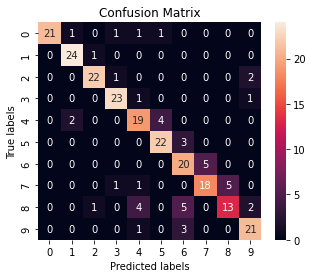

% of correctly classified songs: 0.812


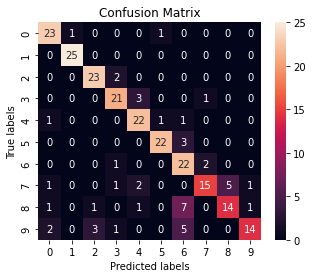

% of correctly classified songs: 0.804


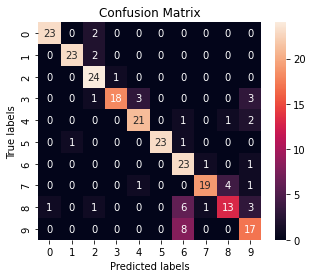

% of correctly classified songs: 0.816


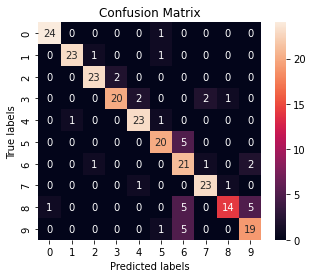

% of correctly classified songs: 0.84


In [29]:
gen_conf_matrices(save_dir)

This performance is much better that would be expected based on the validation accuracy during the training process. One explanation is that majority voting results in much better accuracy than generating predictions with individual augmented samples. 

To test this hypothesis, I generated the predictions one of the original samples of each song in the validation set. 

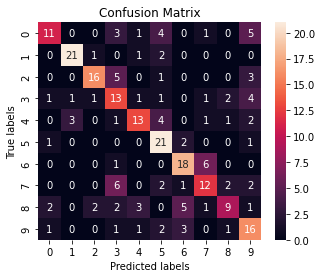

% of correctly classified songs: 0.6


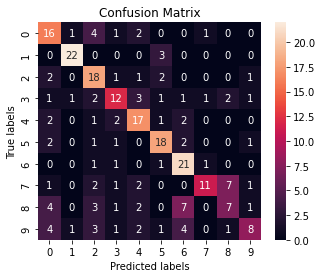

% of correctly classified songs: 0.6


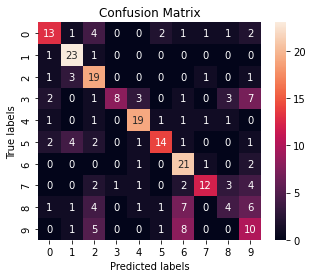

% of correctly classified songs: 0.572


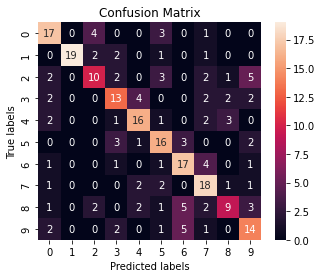

% of correctly classified songs: 0.596


In [44]:
def gen_conf_matrices_val_samples(save_dir):
    #Generate a confusion matrix of the validation data for each model
    to_labels = lambda int_ : cnn.labelmap[int_]
    for i in range(4):
        #load model
        weights_path = save_dir + f'\cp_{i}.ckpt'
        cnn.load_from_weights(weights_path)
        #performance on some samples
        with open(f'val_inds_{i}.npy', 'rb') as f:
            val_inds = np.load(f)
        y_true, y_pred = cnn.get_orig_val_preds(val_inds)
        
        #make confusion matrix
        y_true = list(map(to_labels, y_true))
        y_pred = list(map(to_labels, y_pred))
        cm = confusion_matrix(y_true, y_pred, labels=list(cnn.labelmap.values()))
        cm_df = pd.DataFrame(cm)

        #Plotting
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('True labels')
        plt.xlabel('Predicted labels')
        plt.show()
        
        #performance metrics
        print(f"% of correctly classified songs: {metrics.accuracy_score(y_true, y_pred)}")
        
gen_conf_matrices_val_samples(save_dir)

This confirms that majority voting over the augmented samples of a song significantly improve the model's performance (~20%). 

An overall validation accuracy of ~80% matches the expected results in the source paper, although the paper quotes much better results without the use of majority vote than this implementation. One observation is that the conv filter dimensions of the final layers in the time and frequency pipelines presented in the paper are invalid. They supposedly used (4, 2) and (2, 4) filters, which would produce an output of invalid dimensionality. I used (2, 2) filters instead. This issue highlights the potential for other errors in the paper, as well as the importance of providing the source code along with research papers so others can easily replicate the results. 

The trained models showed a few persistent classification errors. Some make sense, such as classifying rock as metal. Other are less obvious, such as classifying reggae as metal and pop as reggae. The models perform relatively poorly on reggae and rock. 

## Improvements, conclusion
This work could be extended by weighting the training data based on which genres tend to be confused (eg. rock and metal), thus forcing the model to better distinguish these classes in training. Overall, this is an interesting method to do genre classification by taking advantage of the time and frequency separation which comes from the Mel-spectrogram. 